<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/food_habits_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food habits analytics

## Uploading packages and data

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd

In [ ]:
#Uploading google sheet data from drive
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

#Loading dataset from google sheet
wb1 = gc.open('food_habits')
ws1_data = wb1.sheet1
records_1 = ws1_data.get_all_records()

# Converting to a Pandas DataFrame
df1 = pd.DataFrame.from_records(records_1)
df1.tail(3)

In [ ]:
#Checking the dataframe info
df1.info()

##Data Manipulation

In [ ]:
#Converting date columns to datetime objects
df1['event'] = pd.to_datetime(df1['event'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#Extracting year, month, day of the week, hour and count of ingredients
df1 = df1.assign(year = df1['event'].dt.year,
                 month = df1['event'].dt.month,
                 day = df1['event'].dt.dayofweek,
                 hour = df1['event'].dt.hour,
                 ing_count = [len(i.split(', ')) for i in df1['food']])
df1.tail(3)

In [ ]:
#Filtering the dataframe and assigning categories for 2021 where stomach ache appeared
df1_2021 = df1[(df1['year']==2021) & (df1['ache']==1)].reset_index(drop=True)
df1_2021 = df1_2021.assign(cat = np.select(condlist=[(df1_2021['month']<6), ((df1_2021['month']>=6) & (df1_2021['month']<10)), (df1_2021['month']==10),
                                                    (df1_2021['month']>=11)], choicelist=['milk_diet', 'lactose_free', 'rotavirus', 'post_virus']))
df1_2021.tail(2)

In [ ]:
#Calculating range of days between events and converting to int (days)
df1_2021 = df1_2021.assign(event_2 = df1_2021['event'].shift(fill_value=np.nan))
df1_2021 = df1_2021.assign(num_of_days = (df1_2021['event'] - df1_2021['event_2']))
df1_2021 = df1_2021.assign(num_of_days = df1_2021['num_of_days'].replace(np.nan, 0))
df1_2021 = df1_2021.assign(num_of_days = (df1_2021['num_of_days'].astype(int))/8.64e+13) #==> Converting from ns to days
df1_2021.tail(3)

In [ ]:
#Calculating porcentage of change between stomach ache events
df1_2021 = df1_2021.assign(pct_days = df1_2021['num_of_days'].pct_change())
df1_2021 = df1_2021.assign(pct_days = df1_2021['pct_days'].replace(np.nan, 0))

In [ ]:
#Replacing int days for name days
days_dict = {0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df1_2021['day'] = df1_2021['day'].replace(to_replace=days_dict)

In [ ]:
#Counting the proportion of stomach aches by the day of the week
df1_2021['day'].value_counts(normalize=True)

In [ ]:
#Counting the proportion of stomach aches by hour of the day
df1_2021['hour'].value_counts(normalize=True)

In [ ]:
#Transforming aching meals into list
ache_1 = df1[df1['ache']==1]['food'].str.cat(sep=', ').split(", ")
ache_1[:5]

In [ ]:
#Building a dictionary of occurrences for each food
import collections
ache_occurrences = collections.Counter(ache_1)
ache_occurrences.get('bread')

In [ ]:
#Transforming list of aching meals into series
ache_meal_1 = pd.Series(data=ache_1)
ache_meal_1.tail()

In [ ]:
#Counting top foods in diet
ache_meal_1 = ache_meal_1.value_counts().reset_index(name='count').rename(columns={'index':'food'})
ache_meal_1.head()

In [ ]:
#Exporting to excel into local disk
#from google.colab import files
#ache_meal_1.to_excel('food_count.xlsx', index=False) #==> Excluding index from file
#files.download('food_count.xlsx')

##Data Visualization

In [ ]:
#Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (10, 4)})

In [ ]:
#Plotting the top 10 ingredients in diet
sns.barplot(x='food', y='count', data=ache_meal_1[:10])
plt.title('Top 10 ingredients in diet in 2021')
plt.show()

In [ ]:
#Plotting the number of stomach ache by day of the week
sns.countplot(x='day', data=df1_2021, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Count of stomach ache by day of the week in 2021')
plt.show()

In [ ]:
#Plotting the number of stomach ache by month
sns.countplot(x='month', data=df1_2021, hue='cat')
plt.title('Count of stomach ache by month in 2021')
plt.show()

In [ ]:
#Plotting the spread of stomache ache by hour of the day
sns.scatterplot(x='event', y='hour', data=df1_2021, hue='cat')
plt.title('Stomach Ache by hour of the day in 2021')
plt.show()

###Variability graphs

In [ ]:
#Plotting the boxplot of days between stomach ache
sns.boxplot(x='num_of_days', y='cat', data=df1_2021, hue='cat')
plt.title('Days without stomach ache - Before and after first diagnose in 2021')
plt.show()

In [ ]:
#Plotting the boxplot of number of ingredients present in diet
sns.boxplot(x='ing_count', y='cat', data=df1_2021, hue='cat')
plt.title('Number of ingredients in diet - Before and after first diagnose in 2021')
plt.show()

In [ ]:
#Plotting the histogram of hours for stomach ache
sns.histplot(x='hour', data=df1_2021, hue='cat')
plt.title('Most common hours for stomach ache - 2021')
plt.show()

# Facilities analytics

## Uploading packages and data

In [1]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

In [2]:
# Setting the plot size
sns.set(rc = {'figure.figsize': (12, 5)})

In [8]:
# Uploading google sheet data from drive
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc2 = gspread.authorize(creds)

# Loading dataset from google sheet
wb2 = gc2.open('facilities_data')
ws2_data = wb2.sheet1
records_2 = ws2_data.get_all_records()

# Converting to a Pandas DataFrame
df2 = pd.DataFrame.from_records(records_2)
df2.tail(1)

,event,count,large,unload,float,cause
696,2023-01-28 11:10:00,1,0,0,0,


In [9]:
# Checking the dataframe info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   event   697 non-null    object
 1   count   697 non-null    int64 
 2   large   697 non-null    int64 
 3   unload  697 non-null    int64 
 4   float   697 non-null    object
 5   cause   697 non-null    object
dtypes: int64(3), object(3)
memory usage: 32.8+ KB


##Data Manipulation

In [10]:
# Converting date columns to datetime objects
df2['event'] = pd.to_datetime(df2['event'], format='%Y-%m-%d %H:%M:%S')

In [11]:
# Extracting year, month, day of the week, hour and date categories
df2 = df2.assign(year = df2['event'].dt.year,
                 month = df2['event'].dt.month,
                 weeknum = df2['event'].dt.isocalendar().week,
                 day = df2['event'].dt.day_name(),
                 hour = df2['event'].dt.hour,
                 date = df2['event'].dt.round('D')) #=> Gets rid of hour-min-sec

In [12]:
# Extracting cumulative count category
df2 = df2.assign(cum_count = df2['count'].cumsum())
df2.tail(1)

,event,count,large,unload,float,cause,year,month,weeknum,day,hour,date,cum_count
696,2023-01-28 11:10:00,1,0,0,0,,2023,1,4,Saturday,11,2023-01-28,675


## Facilities EDA 

In [13]:
# EDA using interact
col_list = ['month', 'weeknum', 'day', 'hour']
unload_list = [0, 1]
@interact(Cat = col_list, Unload = unload_list)
def proportion(Cat, Unload):
  return df2[(df2['count']!=0) & (df2['unload']==Unload)].value_counts(subset=Cat, normalize=True, dropna=False).reset_index(name='proportion')

interactive(children=(Dropdown(description='Cat', options=('month', 'weeknum', 'day', 'hour'), value='month'),…

## Data Visualization

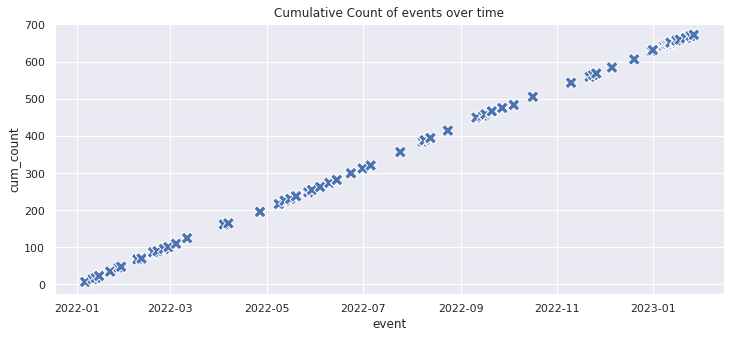

In [15]:
# Scatterplot of facilitites data
sns.scatterplot(x='event', y='cum_count', data=df2[df2['unload']==0])
sns.scatterplot(x='event', y='cum_count', data=df2[df2['unload']==1], style='unload', markers='X', s=150, legend=False)
plt.title('Cumulative Count of events over time')
plt.show()

In [16]:
# Interactive plot of facilitites data
@interact(Cat = col_list)
def plot_facilities(Cat):
  sns.barplot(x=Cat, y='Count', data=df2.groupby([Cat, 'unload']).agg(Count = ('count', 'sum')).reset_index(), hue='unload', palette=['#e56717', '#007fff'])
  plt.title(f'Facilities data for {Cat}')
  plt.show()

interactive(children=(Dropdown(description='Cat', options=('month', 'weeknum', 'day', 'hour'), value='month'),…